In [1]:
from IPython.display import display, HTML
                                                display(HTML("<style>.container { width:95% !important; }</style>"))


Load the modules

In [2]:
import os
import datetime
import netCDF4
import numpy as np
import pprint
import sys
import time
import matplotlib.pyplot as plt
import imageio
import dask
import pysteps

Pysteps configuration file found at: /home/mpvginde/pylibs/pysteps/pysteps/pystepsrc



Set the commandline arguments, default argumets and directories

In [3]:
# Commandline
startdate = "202303141320"
startdate = datetime.datetime.strptime(startdate,"%Y%m%d%H%M")
fc_length = 12
nens = 2
ncores = 4
casetype = 'reference'

# Defaults
threshold = 0.1
ncascade = 8

# Directories
dir_base = "/home/mpvginde/hackaton/" # change me
if casetype == 'reference':
    dir_cascade = os.path.join(dir_base,f'nwp/{casetype}',startdate.strftime('%Y%m%d'),f'ncascade_levels_{ncascade}')
else
    dir_cascade = os.path.join(dir_base,f'nwp/{casetype}',startdate.strftime('%Y%m%d'))
dir_motion = dir_cascade
dir_skill = os.path.join(dir_base,'skill')
dir_gif = os.path.join(dir_base,'gifs')
dir_nwc = os.path.join(dir_base,'nwc')
os.makedirs(dir_nwc,exist_ok=True)
os.makedirs(dir_gif,exist_ok=True)

data_src_radar = "rmi"
data_src_nwp = "rmi_nwp"

root_path = os.path.join(dir_base,'radar') #pysteps.rcparams.data_sources[data_src_radar]["root_path"]
path_fmt = f'{casetype}/%Y%m%d' #pysteps.rcparams.data_sources[data_src_radar]["path_fmt"]
if casetype == 'reference':
    fn_pattern = '%Y%m%d%H%M%S.rad.bhbjbwfa.comp.rate.qpe2_mfb_mfb' #pysteps.rcparams.data_sources[data_src_radar]["fn_pattern"]
else:
    fn_pattern = '%Y%m%d%H%M%S.rad.bhbjbwdnfa.comp.rate.qpe2' #pysteps.rcparams.data_sources[data_src_radar]["fn_pattern"]
fn_ext = 'hdf' #pysteps.rcparams.data_sources[data_src_radar]["fn_ext"]
importer_name = pysteps.rcparams.data_sources[data_src_radar]["importer"]
importer_kwargs = pysteps.rcparams.data_sources[data_src_radar]["importer_kwargs"]
timestep = pysteps.rcparams.data_sources[data_src_radar]["timestep"]

print("Started nowcast with:")
print(r' Startdate: %s' % startdate.strftime("%Y-%m-%d %H:%M"))
print(r' Forecast length: %i timesteps' % fc_length)
print(r' Number of ensemble members: %i' % nens)
print(r' Number of workers: %i' % ncores)
print(r' Rain/No-rain threshold: %.2f' % threshold)
print(r' Number of cascade levels: %i' % ncascade)
print(r' Motion vectors are loaded from: %s' % dir_motion)
print(r' Cascade decompositions are loaded from: %s' % dir_cascade)
print(r' NWP skill is saved in: %s' % dir_skill)
print(r' Nowcast netCDF file is saved in: %s' % dir_nwc)
print('')

Started nowcast with:
 Startdate: 2023-03-14 13:20
 Forecast length: 12 timesteps
 Number of ensemble members: 2
 Number of workers: 4
 Rain/No-rain threshold: 0.10
 Number of cascade levels: 8
 Motion vectors are loaded from: /home/mpvginde/hackaton/nwp/reference/20230314
 Cascade decompositions are loaded from: /home/mpvginde/hackaton/nwp/reference/20230314
 NWP skill is saved in: /home/mpvginde/hackaton/skill
 Nowcast netCDF file is saved in: /home/mpvginde/hackaton/nwc



Load and preprocess the radar data

In [4]:
print('Loading and preprocessing radar analysis...')
fn_radar = pysteps.io.find_by_date(
        date = startdate,
        root_path = root_path,
        path_fmt = path_fmt,
        fn_pattern = fn_pattern,
        fn_ext = fn_ext,
        timestep = timestep,
        num_prev_files = 2
)

importer_radar = pysteps.io.get_method(importer_name,"importer")
r_radar, _, metadata_radar = pysteps.io.read_timeseries(
        inputfns = fn_radar,
        importer = importer_radar,
        legacy=False
)

metadata_nwc = metadata_radar.copy()
metadata_nwc['shape'] = r_radar.shape[1:]

# 4. Prepare the radar analyses
converter = pysteps.utils.get_method("mm/h")
r_radar, metadata_radar = converter(r_radar,metadata_radar)

r_radar[r_radar < threshold] = 0.0
metadata_radar["threshold"] = threshold

r_obs = r_radar[-1,:,:].copy()
metadata_obs = metadata_radar.copy()

transformer = pysteps.utils.get_method("dB")
r_radar, metadata_radar = transformer(
        R = r_radar,
        metadata = metadata_radar,
        threshold = threshold,
#        zerovalue=-10.0
)

oflow_method = pysteps.motion.get_method("LK")
v_radar = oflow_method(r_radar)
print('done!')

Loading and preprocessing radar analysis...
done!


Get the available NWP dates, select the closest one and load the velocities and cascade

In [5]:
fcsttimes_nwp = []
for file in os.listdir(dir_motion):
    fcsttimes_nwp.append(
            datetime.datetime.strptime(file.split("_")[2].split('.')[0],'%Y%m%d%H%M%S')
    )

startdate_nwp = startdate + datetime.timedelta(minutes=timestep)
date_nwp = startdate_nwp + max([nwptime - startdate_nwp for nwptime in fcsttimes_nwp if nwptime <= startdate_nwp]) 

model='ao13'
fn_motion = os.path.join(dir_motion,
        r'motion_%s_%s.npy' % (model,date_nwp.strftime('%Y%m%d%H%M%S'))
)
fn_cascade = os.path.join(dir_cascade,
        r'cascade_%s_%s.nc' % (model,date_nwp.strftime('%Y%m%d%H%M%S'))
)

if not os.path.exists(fn_cascade):
    raise Exception('Cascade file %s accompanying motion file %s does not exist' % (fn_cascade,fn_motion))
print(r'Loading NWP cascade and velocities for run started at %s...' % date_nwp.strftime('%Y-%m-%d %H:%M'))
r_decomposed_nwp, v_nwp = pysteps.blending.utils.load_NWP(
        input_nc_path_decomp = fn_cascade,
        input_path_velocities = fn_motion,
        start_time=np.datetime64(startdate_nwp), 
        n_timesteps=fc_length
)

# 5.bis Make sure the NWP cascade and velocity fields have an extra 'n_models' dimension
r_decomposed_nwp = np.stack([r_decomposed_nwp])
v_nwp = np.stack([v_nwp])
print('done!')

Loading NWP cascade and velocities for run started at 2023-03-14 02:05...
done!


Prepare the netCDF exporter-function

In [6]:
# def write_netCDF(R):
#     R, _ = converter(R, metadata_radar)
#     pysteps.io.export_forecast_dataset(R, exporter)

# exporter = pysteps.io.initialize_forecast_exporter_netcdf(
#         outpath = dir_nwc,
#         outfnprefix = 'blended_nowcast_%s' % startdate.strftime("%Y%m%d%H%M"),
#         startdate = startdate_nwp,
#         timestep = timestep,
#         n_timesteps = fc_length,
#         shape = metadata_nwc['shape'],
#         n_ens_members = nens,
#         metadata = metadata_nwc,
#         incremental = 'timestep'
# )

Start the current updated nowcast

In [7]:
import importlib
importlib.reload(pysteps.blending.steps)


r_nwc,_ ,_ = pysteps.blending.steps.forecast(
        precip = r_radar,
        precip_models = r_decomposed_nwp,
        velocity = v_radar,
        velocity_models = v_nwp,
        timesteps = fc_length,
        timestep = timestep,
        issuetime = startdate,
        n_ens_members = nens,
        n_cascade_levels = ncascade,
        blend_nwp_members = False,
        precip_thr = metadata_radar['threshold'],
        kmperpixel = metadata_radar['xpixelsize']/1000.0,
        extrap_method = 'semilagrangian',
        decomp_method = 'fft',
        bandpass_filter_method = 'gaussian',
        noise_method = 'nonparametric',
        noise_stddev_adj = 'auto',
        ar_order = 2,
        vel_pert_method = None,
        weights_method = 'bps',
        conditional = False,
        probmatching_method = 'cdf',
        mask_method = 'incremental',
        callback = None,
        return_output = True,
        seed = 24,
        num_workers = ncores,
        fft_method = 'numpy',
        domain = 'spatial',
        outdir_path_skill = dir_skill,
        extrap_kwargs = None,
        filter_kwargs = None,
        noise_kwargs = None,
        vel_pert_kwargs = None,
        clim_kwargs = None,
        mask_kwargs = None,
        measure_time = True
)

r_nwc, metadata_nwc = transformer(
        R = r_nwc,
        threshold = -10,
        inverse = True
)

#pysteps.io.close_forecast_files(exporter)
print("nowcast done!")

STEPS blending

Inputs
------
forecast issue time:         2023-03-14T13:20:00
input dimensions:            700x700
km/pixel:                    1.0
time step:                   5 minutes

NWP and blending inputs
-----------------------
number of (NWP) models:      1
blend (NWP) model members:   False
decompose (NWP) models:      no

Methods
-------
extrapolation:               semilagrangian
bandpass filter:             gaussian
decomposition:               fft
noise generator:             nonparametric
noise adjustment:            yes
velocity perturbator:        None
blending weights method:     bps
conditional statistics:      no
precip. mask method:         incremental
probability matching:        cdf
FFT method:                  numpy
domain:                      spatial

Parameters
----------
number of time steps:        12
ensemble size:               2
parallel threads:            4
number of cascade levels:    8
order of the AR(p) model:    2
precip. intensity threshold: -10.

Start the old / original nowcast

In [8]:
from pysteps.blending.steps_old import forecast as forecast_old

In [9]:
r_old = forecast_old(
        precip = r_radar,
        precip_models = r_decomposed_nwp,
        velocity = v_radar,
        velocity_models = v_nwp,
        timesteps = fc_length,
        timestep = timestep,
        issuetime = startdate,
        n_ens_members = nens,
        n_cascade_levels = ncascade,
        blend_nwp_members = False,
        precip_thr = metadata_radar['threshold'],
        kmperpixel = metadata_radar['xpixelsize']/1000.0,
        extrap_method = 'semilagrangian',
        decomp_method = 'fft',
        bandpass_filter_method = 'gaussian',
        noise_method = 'nonparametric',
        noise_stddev_adj = 'auto',
        ar_order = 2,
        vel_pert_method = None,
        weights_method = 'bps',
        conditional = False,
        probmatching_method = 'cdf',
        mask_method = 'incremental',
        callback = None,
        return_output = True,
        seed = 24,
        num_workers = ncores,
        fft_method = 'numpy',
        domain = 'spatial',
        outdir_path_skill = dir_skill,
        extrap_kwargs = None,
        filter_kwargs = None,
        noise_kwargs = None,
        vel_pert_kwargs = None,
        clim_kwargs = None,
        mask_kwargs = None,
        measure_time = False
)

r_old, metadata_old = transformer(
        R = r_old,
        threshold = -10,
        inverse = True
)

print("nowcast done!")

STEPS blending

Inputs
------
forecast issue time:         2023-03-14T13:20:00
input dimensions:            700x700
km/pixel:                    1.0
time step:                   5 minutes

NWP and blending inputs
-----------------------
number of (NWP) models:      1
blend (NWP) model members:   False
decompose (NWP) models:      no

Methods
-------
extrapolation:               semilagrangian
bandpass filter:             gaussian
decomposition:               fft
noise generator:             nonparametric
noise adjustment:            yes
velocity perturbator:        None
blending weights method:     bps
conditional statistics:      no
precip. mask method:         incremental
probability matching:        cdf
FFT method:                  numpy
domain:                      spatial

Parameters
----------
number of time steps:        12
ensemble size:               2
parallel threads:            4
number of cascade levels:    8
order of the AR(p) model:    2
precip. intensity threshold: -10.

Plot the results

In [10]:
from pysteps.visualization import plot_precip_field
from ipywidgets import interactive
from ipywidgets import Layout, interact, IntSlider, FloatSlider
def plotter(t=0,member=0):
    if t==0:
        data = r_obs
        data_old = r_obs
    else:
        data = r_nwc[member,t-1,:,:]
        data_old = r_old[member,t-1,:,:]
    fig = plt.figure(figsize=(18,10))
    fig.add_subplot(1,2,1)
    plot_precip_field(data_old,
                      geodata=metadata_obs,
                      colorscale="STEPS-BE",
                      title="Original blended nowcast for %s + %i min" % (startdate.strftime('%Y-%m-%d %H:%M'), (t)*5),
                     )
    fig.add_subplot(1,2,2)
    plot_precip_field(data,
                      geodata=metadata_obs,
                      colorscale="STEPS-BE",
                      title="Hackaton blended nowcast for %s + %i min" % (startdate.strftime('%Y-%m-%d %H:%M'), (t)*5),
                     )
    plt.tight_layout()
    plt.show()
    
interactive_pcp = interactive(plotter,t=IntSlider(0, 0, r_nwc.shape[1]-1, 1),member=list(range(r_nwc.shape[0])))
interactive_pcp

interactive(children=(IntSlider(value=0, description='t', max=11), Dropdown(description='member', options=(0, …

In [11]:
def plot_cascade_level(
        cascade_level,
        ax=None,
        geodata=None,
        title=None,
        colorbar=True,
        cax=None,
        vmax=None
        ):
    from pysteps.visualization.utils import get_geogrid, get_basemap_axis
    import matplotlib as mpl
    from matplotlib import cm, colors
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap
    
    nlat, nlon = cascade_level.shape
    x_grid, y_grid, extent, regular_grid, origin = get_geogrid(
        nlat,nlon, geodata=geodata
        )
    cascade_level = cascade_level.copy()
    ax = get_basemap_axis(extent, ax=ax, geodata=geodata,map_kwargs={})
    cascade_level = np.ma.masked_invalid(cascade_level)

    # create colormap
    top = mpl.colormaps['Oranges_r'].resampled(128)
    bottom = mpl.colormaps['Blues'].resampled(128)
    
    newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                           bottom(np.linspace(0, 1, 128))))
    newcmp = ListedColormap(newcolors, name='OrangeBlue')
    if vmax is None:
        vmax = np.max(abs(cascade_level))    
    if (x_grid is None) or (y_grid is None):
        im = ax.imshow(
            cascade_level,
            cmap=newcmp,
            extent=extent,
            interpolations="nearest",
            origin=origin,
            zorder=10
            )
    else:
        im = ax.pcolormesh(
            x_grid,
            y_grid,
            cascade_level,
            vmin=-vmax,
            vmax=vmax,
            cmap=newcmp,
            zorder=10
            )
    plt.title(title)
    
    if colorbar:
        cbar = plt.colorbar(im,shrink=0.8,cax=cax)
        
    return(ax)




In [12]:
import importlib



In [13]:
import pysteps.blending.steps_dev
importlib.reload(pysteps.blending.steps_dev)
r_dia, ncasc, pcasc, nextr, pextr, nrecdec, precdec = pysteps.blending.steps_dev.forecast(
        precip = r_radar,
        precip_models = r_decomposed_nwp,
        velocity = v_radar,
        velocity_models = v_nwp,
        timesteps = fc_length,
        timestep = timestep,
        issuetime = startdate,
        n_ens_members = nens,
        n_cascade_levels = ncascade,
        blend_nwp_members = False,
        precip_thr = metadata_radar['threshold'],
        kmperpixel = metadata_radar['xpixelsize']/1000.0,
        extrap_method = 'semilagrangian',
        decomp_method = 'fft',
        bandpass_filter_method = 'gaussian',
        noise_method = 'nonparametric',
        noise_stddev_adj = 'auto',
        ar_order = 2,
        vel_pert_method = None,
        weights_method = 'bps',
        conditional = False,
        probmatching_method = 'cdf',
        mask_method = 'incremental',
        callback = None,
        return_output = True,
        seed = 24,
        num_workers = ncores,
        fft_method = 'numpy',
        domain = 'spatial',
        outdir_path_skill = dir_skill,
        extrap_kwargs = None,
        filter_kwargs = None,
        noise_kwargs = None,
        vel_pert_kwargs = None,
        clim_kwargs = None,
        mask_kwargs = None,
        measure_time = True
)

r_dia, metadata_nwc = transformer(
        R = r_dia,
        threshold = -10,
        inverse = True
)



STEPS blending

Inputs
------
forecast issue time:         2023-03-14T13:20:00
input dimensions:            700x700
km/pixel:                    1.0
time step:                   5 minutes

NWP and blending inputs
-----------------------
number of (NWP) models:      1
blend (NWP) model members:   False
decompose (NWP) models:      no

Methods
-------
extrapolation:               semilagrangian
bandpass filter:             gaussian
decomposition:               fft
noise generator:             nonparametric
noise adjustment:            yes
velocity perturbator:        None
blending weights method:     bps
conditional statistics:      no
precip. mask method:         incremental
probability matching:        cdf
FFT method:                  numpy
domain:                      spatial

Parameters
----------
number of time steps:        12
ensemble size:               2
parallel threads:            4
number of cascade levels:    8
order of the AR(p) model:    2
precip. intensity threshold: -10.

In [14]:
def plotter(t=0,level=0,crange=4):
    
    npower = ncasc[2:,level,:,:].std(axis=(1,2))
    npowerextr = nextr[:,level,:,:].std(axis=(1,2))
    npowerrecdec = nrecdec[:,level,:,:].std(axis=(1,2))
    ppower = pcasc[2:,level,:,:].std(axis=(1,2))
    ppowerextr = np.nanstd(pextr[:,level,:,:],axis=(1,2))
    ppowerrecdec = np.nanstd(precdec[:,level,:,:],axis=(1,2))

    
    gs_kw = dict(height_ratios=[1,4,4,4])
    fig, axs = plt.subplots(4,2,figsize=(16,16),gridspec_kw=gs_kw)
    
    x = np.arange(npower.shape[0])
    
    plt.axes(axs[0,0])
    plt.plot(x,npower)
    plt.plot(x,npowerextr,c="red")
    plt.plot(x,npowerrecdec,c="green")
    plt.ylim(0,1.5)
    plt.scatter(t,npower[t],s=10,c='black')
    plt.scatter(t,npowerextr[t],s=10,c='black')
    plt.title("Power")
         
    plt.axes(axs[1,0])
    plot_cascade_level(ncasc[t+2,level,:,:],
              geodata=metadata_obs,
              title = f"Noise for cascade level after AR2 at {level} \n timestep {t+1}",
              vmax=crange)
    
    plt.axes(axs[2,0])
    plot_cascade_level(nextr[t,level,:,:],
              geodata=metadata_obs,
              title = f"Noise for cascade level after advection at {level} \n timestep {t+1}",
              vmax=crange)
    
    plt.axes(axs[3,0])
    plot_cascade_level(nrecdec[t,level,:,:],
              geodata=metadata_obs,
              title = f"Noise for cascade level after advection of recomposition at {level} \n timestep {t+1}",
              vmax=crange)
    
     
    plt.axes(axs[0,1])
    plt.plot(x,ppower)
    plt.plot(x,ppowerextr,c="red")
    plt.plot(x,ppowerrecdec,c='green')
    plt.ylim(0,1.5)
    plt.scatter(t,ppower[t],s=10,c='black')
    plt.scatter(t,ppowerextr[t],s=10,c='black')

    plt.title("Power")
         
    plt.axes(axs[1,1])
    plot_cascade_level(pcasc[t+2,level,:,:],
              geodata=metadata_obs,
              title = f"Precipitation for cascade level after AR2 at {level} \n timestep {t+1}",
              vmax=crange)
    
    plt.axes(axs[2,1])
    plot_cascade_level(pextr[t,level,:,:],
              geodata=metadata_obs,
              title = f"precipiation for cascade level after advection at {level} \n timestep {t+1}",
              vmax=crange)
    
    plt.axes(axs[3,1])
    plot_cascade_level(precdec[t,level,:,:],
              geodata=metadata_obs,
              title = f"precipiation for cascade level after advection of recomposition at {level} \n timestep {t+1}",
              vmax=crange)
    
    
    plt.tight_layout()
    
    
    plt.show()  
    
interactive_pcp = interactive(plotter,t=IntSlider(0, 0, ncasc.shape[0]-3, 1),level=list(range(ncasc.shape[1])),crange=FloatSlider(value=4,min=0,max=6,step=0.1))
interactive_pcp

interactive(children=(IntSlider(value=0, description='t', max=11), Dropdown(description='level', options=(0, 1…

In [32]:
def calculatePSD(field, **kwargs):
    if len(field.shape) < 2 or len(field.shape) > 3:
        raise ValueError("the input is not two- or three-dimensional array")
    if np.any(~np.isfinite(field)):
        raise ValueError("field contains non-finite values")

   # defaults
    win_fun = kwargs.get("win_fun", None)
    model = kwargs.get("model", "power-law")
    weighted = kwargs.get("weighted", False)
    rm_rdisc = kwargs.get("rm_rdisc", False)
    fft = kwargs.get("fft_method", "numpy")
    if type(fft) == str:
        fft_shape = field.shape if len(field.shape) == 2 else field.shape[1:]
        fft = utils.get_method(fft, shape=fft_shape)

    field = field.copy()

    # remove rain/no-rain discontinuity
    # All values larger as the minimum are changed in the following way originalValue -> originalValue - (difference between the smallest value larger than the minimum and the minimum)
    if rm_rdisc:
        field[field > field.min()] -= field[field > field.min()].min() - field.min()

    # dims
    if len(field.shape) == 2:
        field = field[None, :, :]
    nr_fields = field.shape[0]
    M, N = field.shape[1:]
    
    if win_fun is not None:
        tapering = utils.tapering.compute_window_function(M, N, win_fun)

        # make sure non-rainy pixels are set to zero
        field -= field.min(axis=(1, 2))[:, None, None]
    else:
        tapering = np.ones((M, N))

    # compute average 2D PSD
    F = np.zeros((M, N), dtype=complex)
    for i in range(nr_fields):
        F += fft.fftshift(fft.fft2(field[i, :, :] * tapering))
    F /= nr_fields
    F = abs(F) ** 2 / F.size

    # compute radially averaged 1D PSD
    psd = utils.spectral.rapsd(F)
    L = max(M, N)

    # wavenumbers
    if L % 2 == 1:
        wn = np.arange(0, int(L / 2) + 1)
    else:
        wn = np.arange(0, int(L / 2))
    return[wn, psd]


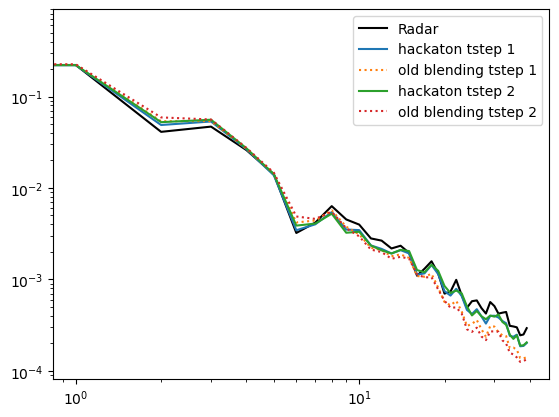

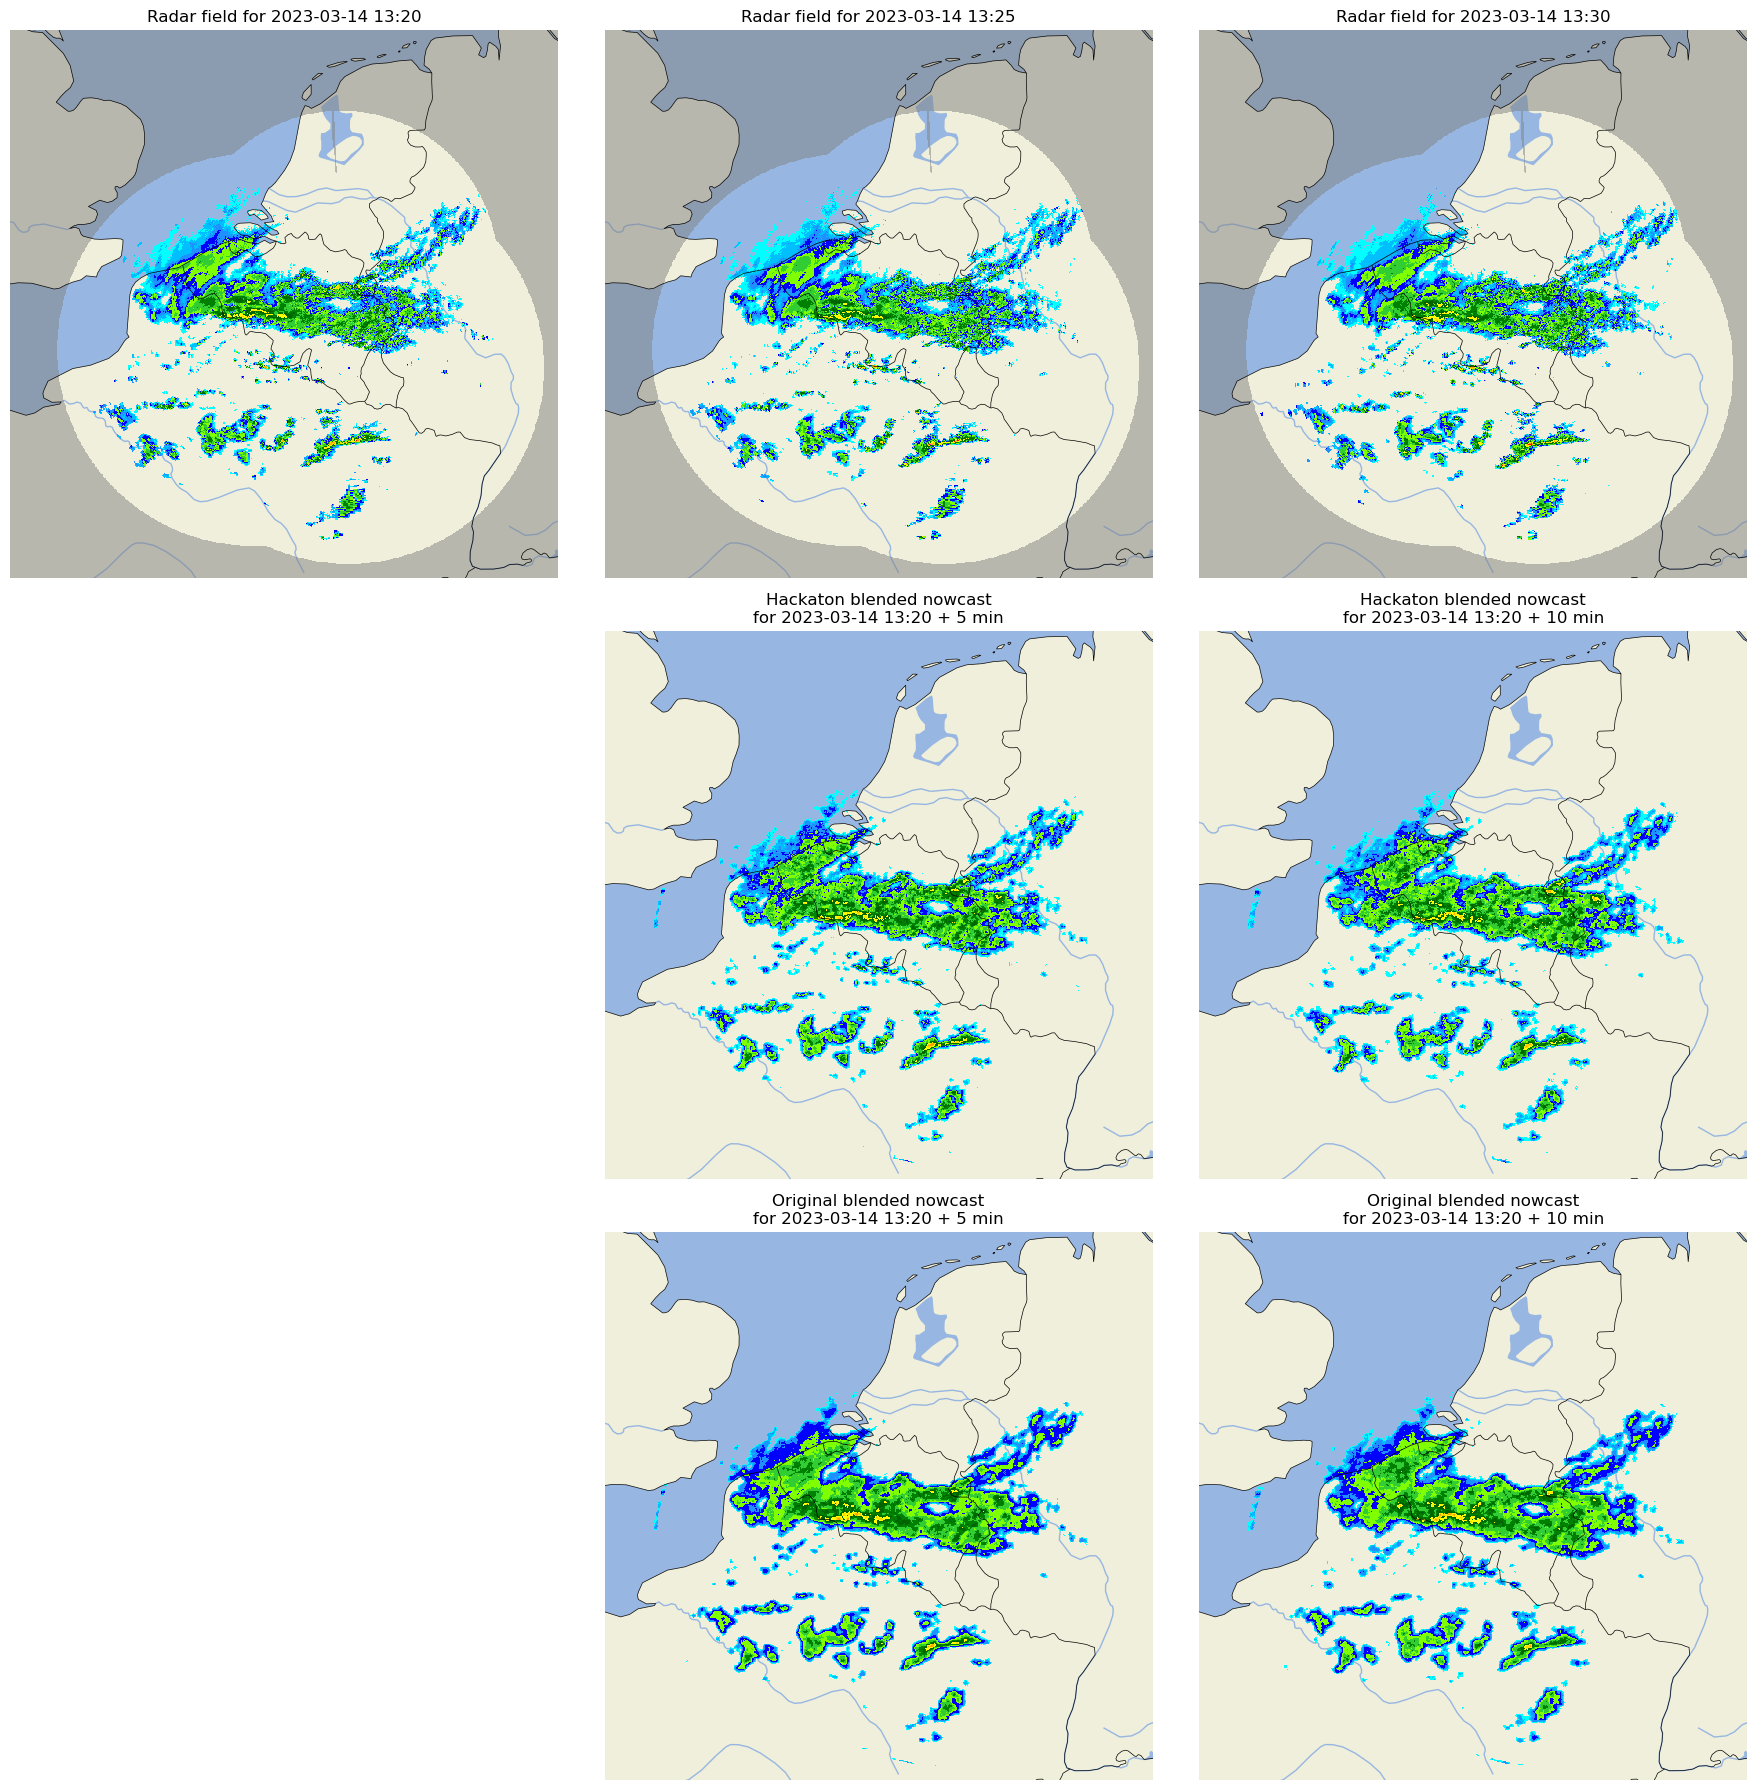

In [56]:

# Defaults
threshold = 0.1
ncascade = 7

# Directories
dir_base = "/home/mpvginde/hackaton/" # change me
if casetype == 'reference':
    dir_cascade = os.path.join(dir_base,f'nwp/{casetype}',startdate.strftime('%Y%m%d'),f'ncascade_levels_{ncascade}')
else:
    dir_cascade = os.path.join(dir_base,f'nwp/{casetype}',startdate.strftime('%Y%m%d'))
dir_motion = dir_cascade
dir_skill = os.path.join(dir_base,'skill')
dir_gif = os.path.join(dir_base,'gifs')
dir_nwc = os.path.join(dir_base,'nwc')
os.makedirs(dir_nwc,exist_ok=True)
os.makedirs(dir_gif,exist_ok=True)

data_src_radar = "rmi"
data_src_nwp = "rmi_nwp"

root_path = os.path.join(dir_base,'radar') #pysteps.rcparams.data_sources[data_src_radar]["root_path"]
path_fmt = f'{casetype}/%Y%m%d' #pysteps.rcparams.data_sources[data_src_radar]["path_fmt"]
if casetype == 'reference':
    fn_pattern = '%Y%m%d%H%M%S.rad.bhbjbwfa.comp.rate.qpe2_mfb_mfb' #pysteps.rcparams.data_sources[data_src_radar]["fn_pattern"]
else:
    fn_pattern = '%Y%m%d%H%M%S.rad.bhbjbwdnfa.comp.rate.qpe2' #pysteps.rcparams.data_sources[data_src_radar]["fn_pattern"]
fn_ext = 'hdf' #pysteps.rcparams.data_sources[data_src_radar]["fn_ext"]
importer_name = pysteps.rcparams.data_sources[data_src_radar]["importer"]
importer_kwargs = pysteps.rcparams.data_sources[data_src_radar]["importer_kwargs"]
timestep = pysteps.rcparams.data_sources[data_src_radar]["timestep"]

print("Started nowcast with:")
print(r' Startdate: %s' % startdate.strftime("%Y-%m-%d %H:%M"))
print(r' Forecast length: %i timesteps' % fc_length)
print(r' Number of ensemble members: %i' % nens)
print(r' Number of workers: %i' % ncores)
print(r' Rain/No-rain threshold: %.2f' % threshold)
print(r' Number of cascade levels: %i' % ncascade)
print(r' Motion vectors are loaded from: %s' % dir_motion)
print(r' Cascade decompositions are loaded from: %s' % dir_cascade)
print(r' NWP skill is saved in: %s' % dir_skill)
print(r' Nowcast netCDF file is saved in: %s' % dir_nwc)
print('')
print('Loading and preprocessing radar analysis...')
fn_radar = pysteps.io.find_by_date(
        date = startdate,
        root_path = root_path,
        path_fmt = path_fmt,
        fn_pattern = fn_pattern,
        fn_ext = fn_ext,
        timestep = timestep,
        num_prev_files = 2
)

importer_radar = pysteps.io.get_method(importer_name,"importer")
r_radar, _, metadata_radar = pysteps.io.read_timeseries(
        inputfns = fn_radar,
        importer = importer_radar,
        legacy=False
)

metadata_nwc = metadata_radar.copy()
metadata_nwc['shape'] = r_radar.shape[1:]

# 4. Prepare the radar analyses
converter = pysteps.utils.get_method("mm/h")
r_radar, metadata_radar = converter(r_radar,metadata_radar)

r_radar[r_radar < threshold] = 0.0
metadata_radar["threshold"] = threshold

r_obs = r_radar[-1,:,:].copy()
metadata_obs = metadata_radar.copy()

transformer = pysteps.utils.get_method("dB")
r_radar, metadata_radar = transformer(
        R = r_radar,
        metadata = metadata_radar,
        threshold = threshold,
#        zerovalue=-10.0
)

oflow_method = pysteps.motion.get_method("LK")
v_radar = oflow_method(r_radar)
print('done!')

fcsttimes_nwp = []
for file in os.listdir(dir_motion):
    fcsttimes_nwp.append(
            datetime.datetime.strptime(file.split("_")[2].split('.')[0],'%Y%m%d%H%M%S')
    )

startdate_nwp = startdate + datetime.timedelta(minutes=timestep)
date_nwp = startdate_nwp + max([nwptime - startdate_nwp for nwptime in fcsttimes_nwp if nwptime <= startdate_nwp]) 

model='ao13'
fn_motion = os.path.join(dir_motion,
        r'motion_%s_%s.npy' % (model,date_nwp.strftime('%Y%m%d%H%M%S'))
)
fn_cascade = os.path.join(dir_cascade,
        r'cascade_%s_%s.nc' % (model,date_nwp.strftime('%Y%m%d%H%M%S'))
)

if not os.path.exists(fn_cascade):
    raise Exception('Cascade file %s accompanying motion file %s does not exist' % (fn_cascade,fn_motion))
print(r'Loading NWP cascade and velocities for run started at %s...' % date_nwp.strftime('%Y-%m-%d %H:%M'))
r_decomposed_nwp, v_nwp = pysteps.blending.utils.load_NWP(
        input_nc_path_decomp = fn_cascade,
        input_path_velocities = fn_motion,
        start_time=np.datetime64(startdate_nwp), 
        n_timesteps=fc_length
)

# 5.bis Make sure the NWP cascade and velocity fields have an extra 'n_models' dimension
r_decomposed_nwp = np.stack([r_decomposed_nwp])
v_nwp = np.stack([v_nwp])
print('done!')


r_nwc_7,_ ,_ = pysteps.blending.steps.forecast(
        precip = r_radar,
        precip_models = r_decomposed_nwp,
        velocity = v_radar,
        velocity_models = v_nwp,
        timesteps = fc_length,
        timestep = timestep,
        issuetime = startdate,
        n_ens_members = nens,
        n_cascade_levels = ncascade,
        blend_nwp_members = False,
        precip_thr = metadata_radar['threshold'],
        kmperpixel = metadata_radar['xpixelsize']/1000.0,
        extrap_method = 'semilagrangian',
        decomp_method = 'fft',
        bandpass_filter_method = 'gaussian',
        noise_method = 'nonparametric',
        noise_stddev_adj = 'auto',
        ar_order = 2,
        vel_pert_method = None,
        weights_method = 'bps',
        conditional = False,
        probmatching_method = 'cdf',
        mask_method = 'incremental',
        callback = None,
        return_output = True,
        seed = 24,
        num_workers = ncores,
        fft_method = 'numpy',
        domain = 'spatial',
        outdir_path_skill = dir_skill,
        extrap_kwargs = None,
        filter_kwargs = None,
        noise_kwargs = None,
        vel_pert_kwargs = None,
        clim_kwargs = None,
        mask_kwargs = None,
        measure_time = True
)

r_nwc_7, metadata_nwc = transformer(
        R = r_nwc_7,
        threshold = -10,
        inverse = True
)

Started nowcast with:
 Startdate: 2023-03-14 13:20
 Forecast length: 12 timesteps
 Number of ensemble members: 2
 Number of workers: 4
 Rain/No-rain threshold: 0.10
 Number of cascade levels: 7
 Motion vectors are loaded from: /home/mpvginde/hackaton/nwp/reference/20230314/ncascade_levels_7
 Cascade decompositions are loaded from: /home/mpvginde/hackaton/nwp/reference/20230314/ncascade_levels_7
 NWP skill is saved in: /home/mpvginde/hackaton/skill
 Nowcast netCDF file is saved in: /home/mpvginde/hackaton/nwc

Loading and preprocessing radar analysis...
done!
Loading NWP cascade and velocities for run started at 2023-03-14 02:05...
done!
STEPS blending

Inputs
------
forecast issue time:         2023-03-14T13:20:00
input dimensions:            700x700
km/pixel:                    1.0
time step:                   5 minutes

NWP and blending inputs
-----------------------
number of (NWP) models:      1
blend (NWP) model members:   False
decompose (NWP) models:      no

Methods
-------
ext

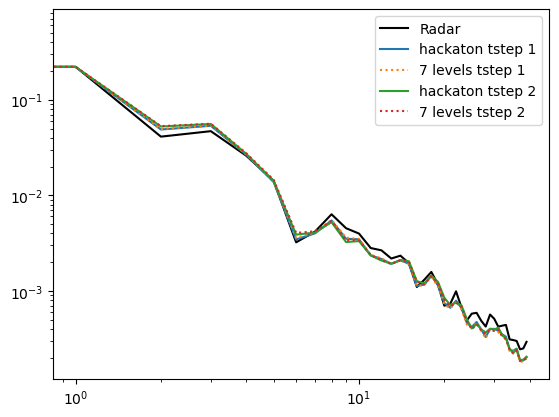

In [61]:
import pysteps.utils as utils
import math
# Reload the radar data for the next steps
fn_valid = pysteps.io.find_by_date(
        date = startdate,
        root_path = root_path,
        path_fmt = path_fmt,
        fn_pattern = fn_pattern,
        fn_ext = fn_ext,
        timestep = timestep,
        num_next_files = 2
)


importer_radar = pysteps.io.get_method(importer_name,"importer")
r_valid, _, metadata_valid = pysteps.io.read_timeseries(
        inputfns = fn_valid,
        importer = importer_radar,
        legacy=False
)

metadata_nwc = metadata_valid.copy()
metadata_nwc['shape'] = r_valid.shape[1:]

# 4. Prepare the radar analyses
converter = pysteps.utils.get_method("mm/h")
r_valid, metadata_valid = converter(r_valid,metadata_valid)

r_valid[r_valid < threshold] = 0.0
metadata_valid["threshold"] = threshold


radar_mask = ~np.isfinite(r_valid)
psd_radar = []
psd_nwc = []
psd_nwc_7 = []
psd_old = []

for i in range(r_valid.shape[0]):
    temp = r_valid[i].copy()
    temp[radar_mask[i]]=0.0
    psd_ = calculatePSD(temp)
    psd_[1] = psd_[1]/np.sum(psd_[1])
    psd_radar.append(psd_)
    
    temp = r_nwc[0][i]
    temp[radar_mask[i]]=0.0
    psd_ = calculatePSD(temp)
    psd_[1] = psd_[1]/np.sum(psd_[1])
    psd_nwc.append(psd_)

    temp = r_nwc_7[0][i]
    temp[radar_mask[i]]=0.0
    psd_ = calculatePSD(temp)
    psd_[1] = psd_[1]/np.sum(psd_[1])
    psd_nwc_7.append(psd_)
    
    temp = r_old[0][i]
    temp[radar_mask[i]]=0.0
    psd_ = calculatePSD(temp)
    psd_[1] = psd_[1]/np.sum(psd_[1])
    psd_old.append(psd_)
    

temp = None
psd_ = None

plt.plot(psd_radar[0][0][0:40],psd_radar[0][1][0:40],color='black',label="Radar")
for t in range(2):
    plt.plot(psd_nwc[t][0][0:40],psd_nwc[t][1][0:40],ls='-',label=f"hackaton tstep {t+1}")
    plt.plot(psd_nwc_7[t][0][0:40],psd_nwc_7[t][1][0:40],ls=':',label=f'7 levels tstep {t+1}')
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()

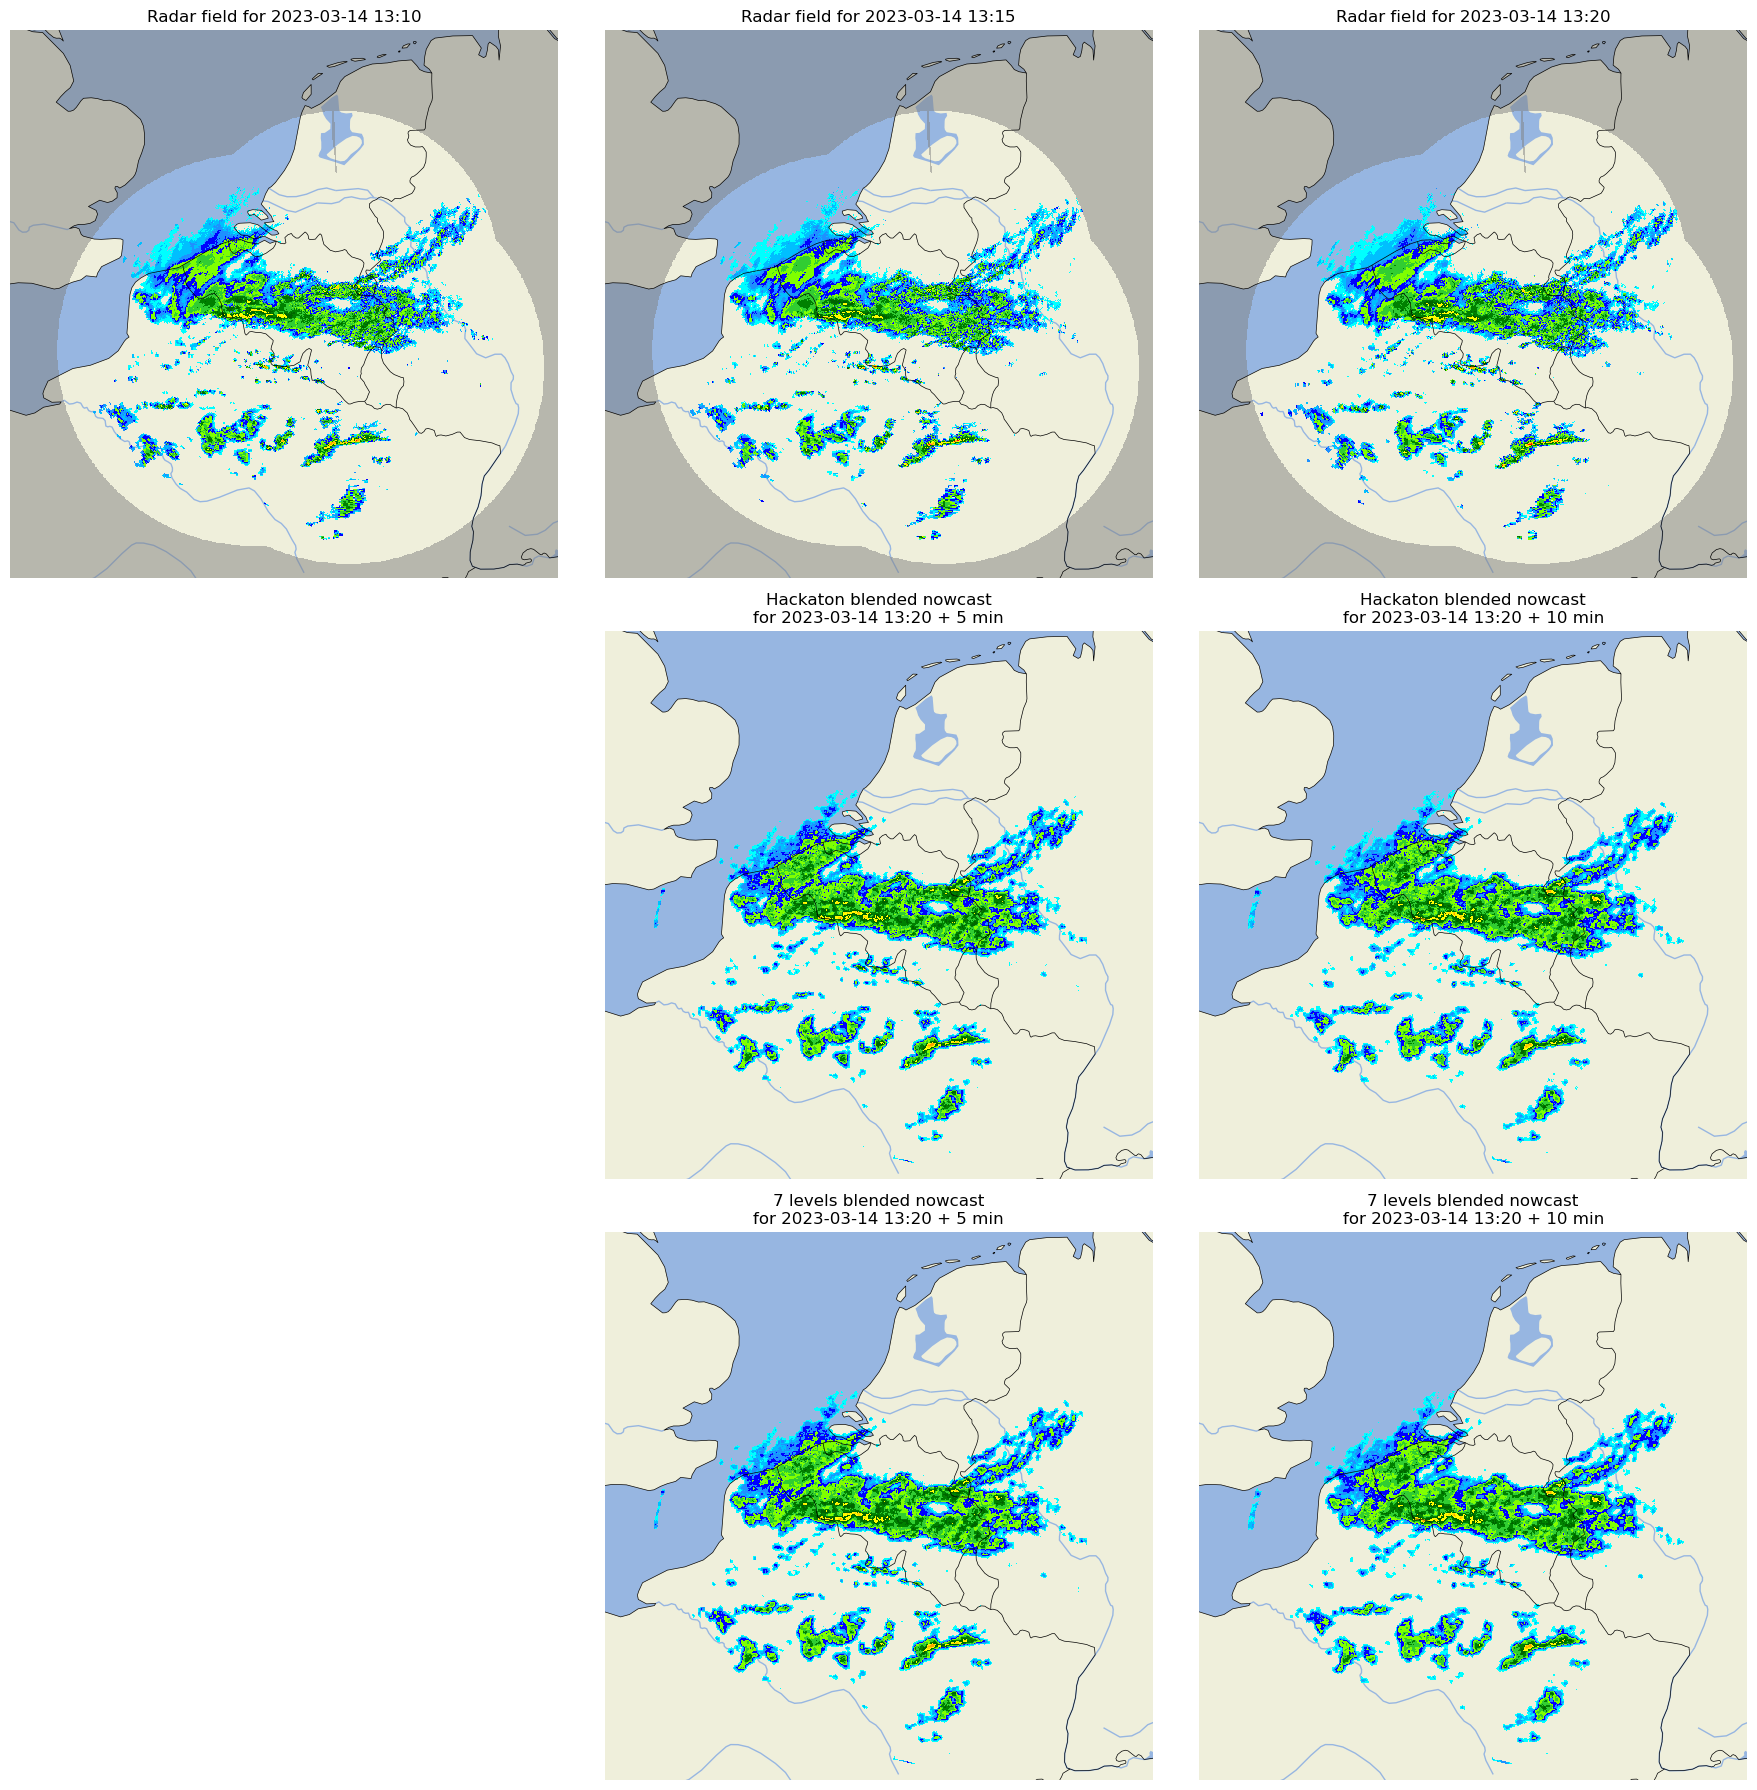

In [63]:
fig = plt.figure(figsize=(18,18))
for i in range(len(metadata_radar['timestamps'])):
    fig.add_subplot(3,3,i+1)
    plot_precip_field(r_valid[i,:,:],
                      geodata=metadata_obs,
                      colorscale="STEPS-BE",
                      title="Radar field for %s" % (metadata_radar['timestamps'][i].strftime('%Y-%m-%d %H:%M'), ),
                      colorbar=False
                     )
for i in range(len(metadata_radar['timestamps'])-1):
    fig.add_subplot(3,3,5+i)
    plot_precip_field(r_nwc[0,i,:,:],
                      geodata=metadata_obs,
                      colorscale="STEPS-BE",
                      title="Hackaton blended nowcast\nfor %s + %i min" % (startdate.strftime('%Y-%m-%d %H:%M'), (i+1)*5),
                      colorbar=False
                     )
for i in range(len(metadata_radar['timestamps'])-1):
    fig.add_subplot(3,3,8+i)
    plot_precip_field(r_nwc_7[0,i,:,:],
                      geodata=metadata_obs,
                      colorscale="STEPS-BE",
                      title="7 levels blended nowcast\nfor %s + %i min" % (startdate.strftime('%Y-%m-%d %H:%M'), (i+1)*5),
                      colorbar=False
                     )
plt.tight_layout()